## Data Validation
This data set has 947 rows, 8 columns. I have validated all variables and I have  made some changes after validation. All the columns are just as described in the data dictionary:
- recipe: numeric values, same as the description. No cleaning is needed.
- calories: numeric values, It contained 52 missing values. Cleaning was made later on.
- carbohydrate: numeric values, It contained 52 missing values. Cleaning was made later on.
- sugar: numeric values, It contained 52 missing values. Cleaning was made later on.
- protein: numeric values, It contained 52 missing values. Cleaning was made later on.
**Note: We noticed that in these 52 missing values all the whole row containing fields calories, carbohydrates, sugar, and protein are missing so because they don't form a huge part of the data we decided to drop them**
- category: 11 categories without missing values, it contained one extra category called _'Chicken Breast'_ that we had to deal with and transform it into _'Chicken'_.
- servings: object that contained 2 extra fields _'6 as snack'_, and _'4 as snack'_ which where turned into their corresponding numbers (_6_ and _4_ respectively) and the whole column was transformed into numeric type.
- high_traffic: It contained one category _'High'_ and lots of missing value  which where assumed to be the low traffic and replaced with the wrod _'Low'_

In [2]:
import warnings
# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder, PowerTransformer, RobustScaler, MinMaxScaler,QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
plt.style.use('ggplot')

In [4]:
df = pd.read_csv('./recipe_site_traffic_2212.csv')
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [5]:
# Check for missing values
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [6]:
# Dealing with missing values
df['high_traffic']=df['high_traffic'].fillna(value="Low")
df = df.dropna()

In [7]:
# validate servings
df['servings'] = df['servings'].replace('4 as a snack','4')
df['servings'] = df['servings'].replace('6 as a snack','6')
df['servings'] = df['servings'].astype(int)

In [8]:
# validate 10 types of category
print(df['category'].unique())
df['category'] = df['category'].replace('Chicken Breast','Chicken')

['Potato' 'Breakfast' 'Beverages' 'One Dish Meal' 'Chicken Breast'
 'Lunch/Snacks' 'Pork' 'Chicken' 'Vegetable' 'Meat' 'Dessert']


In [9]:
#validate any negative values in numeric variables
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,Low
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,Low
5,6,691.15,3.46,1.65,53.93,One Dish Meal,2,High


#### Relationship between calories, carbohydrate, sugar, protein and high_traffic
To spot the non-linear relationship, I decided to make boxplot to further investigate the relationship between calories, carbohydrate, sugar, protein and our target varible - high_traffic. From the boxplots below, there is a week relationship between these numeric variables and high_traffic and there are lots of outliers out there. I found out there is a definite number of servings and it is not a continuous variable, so i decided to further explore it with the categorical types.

[Text(0.5, 1.0, 'Servings vs High Traffic')]

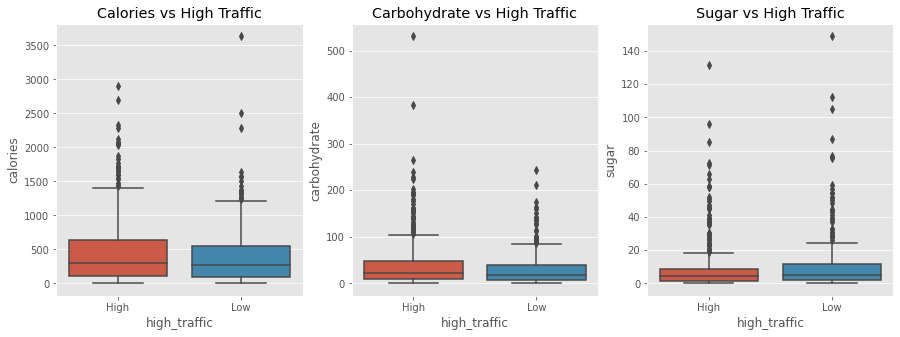

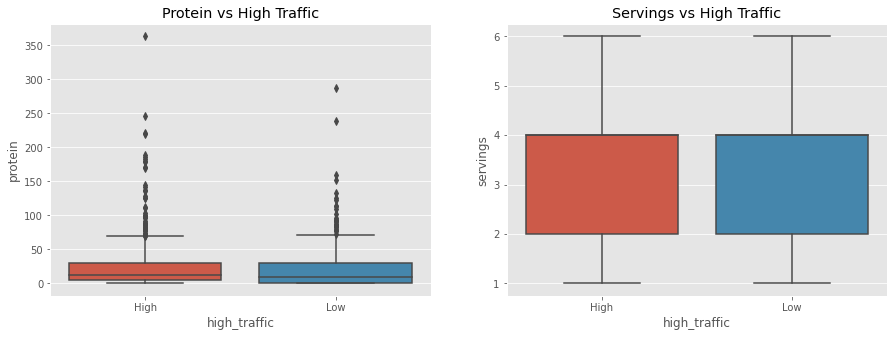

In [10]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

sns.boxplot(data=df,x='high_traffic',y='calories',ax=axes[0]).set(title='Calories vs High Traffic')
sns.boxplot(data=df,x='high_traffic',y='carbohydrate',ax=axes[1]).set(title='Carbohydrate vs High Traffic')
sns.boxplot(data=df,x='high_traffic',y='sugar',ax=axes[2]).set(title='Sugar vs High Traffic')

fig1,axes1 = plt.subplots(1,2,figsize = (15,5))
sns.boxplot(data=df,x='high_traffic',y='protein',ax=axes1[0]).set(title='Protein vs High Traffic')
sns.boxplot(data=df,x='high_traffic',y='servings',ax=axes1[1]).set(title='Servings vs High Traffic')

### Categorical Variables category, servings and high_traffic
Since category and servings are most related to traffic, I checked their characteristics. From the bar chart below, the most common categories are Beverages and Chicken. Also, the most servings is 4.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Potato'),
  Text(1, 0, 'Breakfast'),
  Text(2, 0, 'Beverages'),
  Text(3, 0, 'One Dish Meal'),
  Text(4, 0, 'Chicken'),
  Text(5, 0, 'Lunch/Snacks'),
  Text(6, 0, 'Pork'),
  Text(7, 0, 'Vegetable'),
  Text(8, 0, 'Meat'),
  Text(9, 0, 'Dessert')])

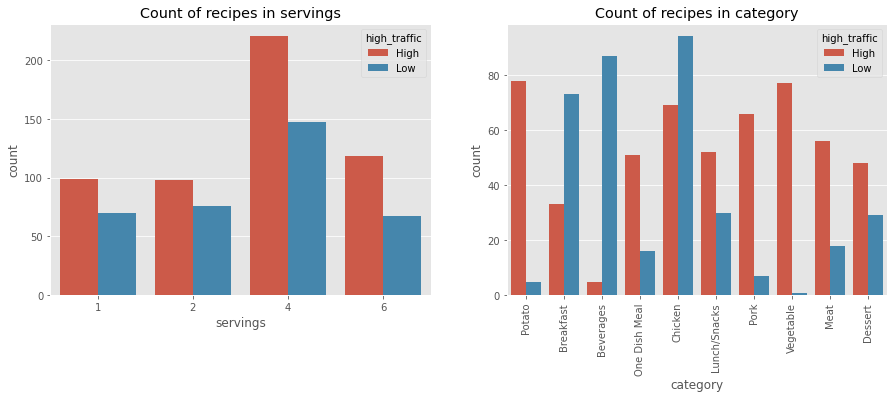

In [11]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
sns.countplot(data=df,x='servings',hue='high_traffic',ax=axes[0]).set(title = 'Count of recipes in servings')
sns.countplot(data=df,x='category',hue='high_traffic',ax=axes[1]).set(title = 'Count of recipes in category')
plt.xticks(rotation = 90)


## Model Fitting & Evaluation
Predicting the price is a classification problem in machine learning. I am choosing the Logestic  Regression model because we our target variable is a binary outcome. The comparison model I am choosing is the Random Forest Classifier model to provide robust and accurate predictions by combining the power of multiple decision trees, reducing overfitting and improving generalization.

For the evaluation, I am choosing **Accuracy Score** and **ROC_AUC_SCORE** to evaluate the model. Accuracy Score show the proportion of correctly predicted instances. ROC_AUC_SCORE measures how well a model can distinguish between two classes (e.g., positive and negative) by assessing the shape of the curve formed when plotting true positive rate against false positive rate.

### Prepare Data for Modelling
To enable modelling, we chose year,model,transmission,mileage,fuelType,tax,engineSize as features, price as target variables. I also have made the following changes:
- Scaled the numeric features
- Converted the categorical variables into dummy_variables.
- Splitted the data into a training set and a test set

In [12]:
feature_cols = ['calories', 'carbohydrate', 'sugar', 'protein', 'category', 'servings']
X = df[feature_cols] # Features
y = df['high_traffic'] # Target Variable

In [13]:
# Define Scalars
rs = RobustScaler()
le = LabelEncoder()

X = pd.get_dummies(X,dtype=float)
y=le.fit_transform(y)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=42,stratify=y)

In [15]:
# I decided not to scale servings becuase it looks like categorical types and doesn't have continuous values
cols_to_scale = {'calories', 'carbohydrate', 'sugar', 'protein'}
for col in cols_to_scale:
        X_train[col] = rs.fit_transform(X_train[[col]])
        X_test[col] = rs.transform(X_test[[col]])

### Linear Regression Model

In [16]:
lr = LogisticRegression(random_state=42)
lr.fit(X_train,y_train)

LogisticRegression(random_state=42)

In [17]:
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)[:,1]

lr_accuracy_score = accuracy_score (y_test,y_pred)
print(f'Accuracy score = {lr_accuracy_score}')
print(f'ROC_AUC score = {roc_auc_score(y_test,y_pred_proba)}')

Accuracy score = 0.7821229050279329
ROC_AUC score = 0.8416407061266875


#### Finding the feature importance

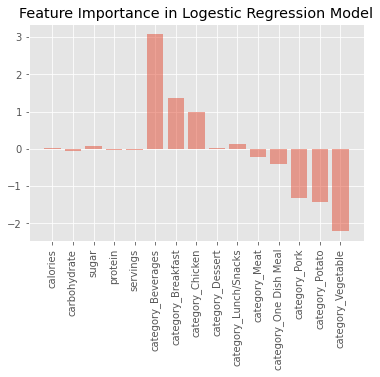

In [18]:
resultdict = {}
for i in range(len(X.columns)):
    resultdict[X.columns[i]] = lr.coef_[0,i]

plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5)
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Logestic Regression Model');

### Random Forest Classification Model

In [19]:
tree = RandomForestClassifier(criterion = 'entropy', max_depth = 15, max_features = 'auto', min_samples_leaf = 4, min_samples_split = 10, n_estimators = 200,random_state=42)

tree.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', max_depth=15, max_features='auto',
                       min_samples_leaf=4, min_samples_split=10,
                       n_estimators=200, random_state=42)

In [20]:
y_pred = tree.predict(X_test)
y_pred_proba = tree.predict_proba(X_test)[:,1]

tree_accuracy_score = accuracy_score(y_test,y_pred)
print(f'Accuracy score {tree_accuracy_score}')
print(f'ROC_AUC score {roc_auc_score(y_test,y_pred_proba)}')

Accuracy score 0.7206703910614525
ROC_AUC score 0.8075025960539979


#### Finding the best parameter for Random Forest Classifier Model

In [21]:
classifier = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1,5,14,15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
grid_search = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Cross-Validation Accuracy: {:.4f}".format(grid_search.best_score_))

best_classifier = grid_search.best_estimator_
test_accuracy = best_classifier.score(X_test, y_test)
print("Test Accuracy: {:.4f}".format(test_accuracy))

Best Parameters:  {'criterion': 'gini', 'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.7527
Test Accuracy: 0.7207


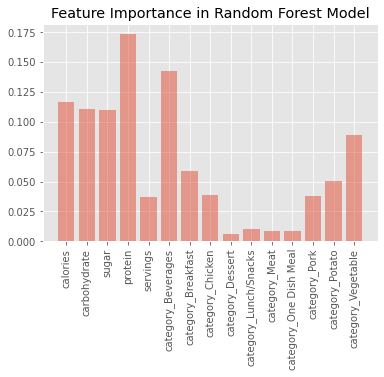

In [22]:
resultdict = {}
importance = tree.feature_importances_
for i in range(len(X.columns)):
    resultdict[X.columns[i]] = importance[i]

plt.bar(resultdict.keys(),resultdict.values(), alpha=0.5)
plt.xticks(rotation='vertical')
plt.title('Feature Importance in Random Forest Model');

## Results
The ROC_AUC score of the Logistic Regression, and the Random Forest Classifier model is 0.84 and 0.80, meaning the **Logistic Regression fits the features better.** The Accuracy score of the Logistic Regression, and the Random Forest Classifier model is 0.78 and 0.72, meaning the **Logistic Regression model has less error in predicting values.**

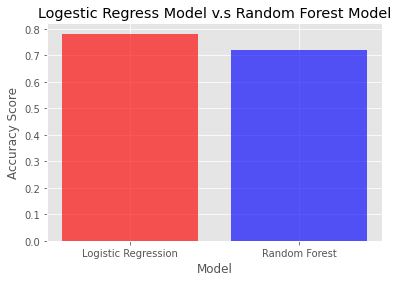

In [23]:
x_axis = ['Logistic Regression','Random Forest']
y_axis = [lr_accuracy_score,tree_accuracy_score]

plt.bar(x_axis,y_axis,color=['red','blue'],alpha = 0.65)
plt.title('Logestic Regress Model v.s Random Forest Model')
plt.xlabel('Model')
plt.ylabel('Accuracy Score')
plt.show()

### Evaluate by Business Criteria
The project manager need to correctly predict whether recipes will have high traffic 80% of the times. That was very hard to achieve but we reached a very close accuracy of 78% using the **Logistic Regression model**.

## Recommendation

To smooth out the difficulities we might face, we can plan to deploy this **Logistic Regression Model** into production. By applying this model, it is able to truely predict around 78% of the recipes being marked by high traffic or low ones. This will help automate the whole process. I will recommend the following steps to ensure the model can be deployed and improved regularly.

1. Test the model in the recent month and compare its prediction to the estimations of the experienced member on new cars.

2. Identify and fix errors to improve accuracy after testing.

3. Fully deploy the model using efficient deployment strategy, such as a web or mobile application or API.

4. Continuously improve the model by collecting more data, feature engineer and fine tuning parameter. This would be the key points to address the limitation from the year and car model variable.
